# 18 Heterogeneous Treatment Effects and Personalization

## From Predicitions to Causal Inference

- ML
  - 예측하는 것
  - $E[Y|X]$을 추정하는 것
  - $X$를 $Y$에 mapping하는 것
- 하지만 실제 비즈니스에서 ML을 넘어서 causal inference로 가야하는 경우가 많다.
- Causal Inference
  - $E[Y|X, T]$ 
  - process of estimating the causal relationship between $Y$ and $T$ under context $X$
  - 결국에는 causal effect를 추정하는 것만이 아니라 최적의 decision을 찾는 것이 목표가 된다.

$$\underset{T}{argmax} \ E[Y|X, T]$$

## From ATE to CATE

- ATE:
    - $E[Y_1 - Y_0]$
    - $E[y'(t)]$ (continuous treatment)
- 비즈니스에서 주로 who do we treat? 이라는 질문을 자주 하게 된다.
- 즉 CATE를 estimate해야 하는 것이다.

$$E[Y_1−Y_0 | X] \ \text{or} \ E[y'(t)|X]$$

- $X$에 대해 conditioning하는 것은 각 unit의 특징에 따라 treatment effect가 다르다는 것을 의미한다.
- 이런 heterogeneity를 이용하여 각 특징에 맞게 적절한 treatment (decision)을 고려할 수 있다.

- elasticity: how much $Y$ changes with $T$
- 각 개별 unit들의 elasticity($\frac{\delta Y_i}{\delta T_i}$)를 알 수 있다면 우리는 적절한 $t$를 각 unit들에게 알맞게 treat할 수 있을 것이다.
- 하지만 이를 알 수 없다. 알려면 동일한 unit에게 treatment을 변화시켜가면서 outcome의 결과를 확인해야 하기 때문이다.

## Predicting Elasticity

- $\frac{\delta Y_i}{ \delta T_i}$을 모르니까 예측해보자
- linear regression을 이용해보자

$$y_i = \beta_0 + \beta_1 t_i + \beta_2 X_i + \beta_3 t_i X_i  + e_i$$

$$\widehat{\frac{\delta y_i}{\delta t_i}} = \hat{\beta_1} + \hat{\beta_3}X_i$$

- 위처럼 모델을 만들면 $X_i$에 따라 다른 elasticity를 예측할 수 있게 된다.
- 실제 데이터로 확인해보자.

- treatment는 randomized 된 것이다.
- 우리의 목표는 feature에 따라 charge를 다르게 가져가는 것이다. 각 unit을 segment하는 것이라고 생각할 수도 있다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [3]:
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
print(prices_rnd.shape)
prices_rnd.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,25.8,1,0.3,7,230
1,22.7,3,0.5,4,190
2,33.7,7,1.0,5,237
3,23.0,4,0.5,5,193
4,24.4,1,1.0,3,252


In [4]:
np.random.seed(123)
train, test = train_test_split(prices_rnd)

- 맨 처음에는 가장 간단한 경우를 생각해보자.
- 아래는 price와 다른 변수의 interaction이 없는 모델이다.

$$sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2}X_i + e_i$$

- 그러면 elasticity는 $\hat{\beta_1}$이고 -2.75 이다.
- 하지만 우리는 좀 더 개별적인 elasticity를 구하고 싶다. ATE가 아니라 CATE를 이용하고 싶은 것이다.

In [6]:
m1 = smf.ols("sales ~ price + temp+C(weekday)+cost", data=train).fit()
m1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,186.7113,1.770,105.499,0.000,183.241,190.181
C(weekday)[T.2],-25.0512,0.924,-27.114,0.000,-26.863,-23.240
C(weekday)[T.3],-24.5834,0.901,-27.282,0.000,-26.350,-22.817
C(weekday)[T.4],-24.3807,0.897,-27.195,0.000,-26.138,-22.623
C(weekday)[T.5],-24.9036,0.894,-27.850,0.000,-26.657,-23.150
C(weekday)[T.6],-24.0921,0.903,-26.693,0.000,-25.862,-22.323
C(weekday)[T.7],-0.8635,0.888,-0.972,0.331,-2.605,0.878
price,-2.7515,0.106,-25.970,0.000,-2.959,-2.544
temp,1.9848,0.060,33.117,0.000,1.867,2.102
cost,4.4718,0.528,8.462,0.000,3.436,5.508


- 다음은 아래와 같은 모델을 생각해보자

$$sales_i = \beta_0 + \beta_1 price_i + \beta_2 price_i * temp_i * + \pmb{\beta_3}X_i + e_i$$

In [5]:
m2 = smf.ols("sales ~ price*temp + C(weekday) + cost", data=train).fit()
m2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.4767,4.371,44.037,0.000,183.907,201.046
C(weekday)[T.2],-25.0805,0.924,-27.143,0.000,-26.892,-23.269
C(weekday)[T.3],-24.5871,0.901,-27.290,0.000,-26.354,-22.821
C(weekday)[T.4],-24.4225,0.897,-27.231,0.000,-26.181,-22.664
C(weekday)[T.5],-24.8953,0.894,-27.844,0.000,-26.648,-23.142
C(weekday)[T.6],-24.1269,0.903,-26.726,0.000,-25.897,-22.357
C(weekday)[T.7],-0.8581,0.888,-0.966,0.334,-2.599,0.883
price,-3.6299,0.618,-5.873,0.000,-4.842,-2.418
temp,1.7459,0.176,9.912,0.000,1.401,2.091
price:temp,0.0366,0.025,1.443,0.149,-0.013,0.086


$$\widehat{\frac{\delta sales_i}{\delta price_i}} = \hat{\beta_1} + \hat{\beta_3}temp_i$$

- 계수를 확인해보면
  - price가 오를수록 sales는 떨어진다.
  - 그런데 온도가 오를수록 그 정도는 less sensitive해진다.
  - 더워질수록 사람들은 ice cream에 돈을 더 사용하는 것이다.

- 다음은 좀 더 복잡한 경우를 살펴보자.
- 다음에는 `price`와 `temp`의 interaction뿐만 아니라 다른 변수들 모두를 고려해보자.

$$sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X_i}*price_i + \pmb{\beta_3}X_i + e_i$$

$$\frac{\delta Sales}{\delta Price} = \beta_1 + \pmb{\beta_2 X_i}$$

In [7]:
m3 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

- 그렇다면 이제 위의 모델들을 이용하여
  - elasticity prediction값을 구해보자
  - $\epsilon$=1로 해서 approximation하자

$$\frac{\delta y}{\delta t} = \dfrac{y(t+\epsilon) - y(t)}{ (t + \epsilon) - t }\ \approx \hat{y}(t+1) - \hat{y}(t)$$

In [8]:
def pred_elasticity(m, df, t="price"):
    return df.assign(**{
        "pred_elast": m.predict(df.assign(**{t:df[t]+1})) - m.predict(df)
    })

In [10]:
pred_elasticity(m1, test).head()

,temp,weekday,cost,price,sales,pred_elast
2648,18.6,7,0.5,10,185,-2.751463
2456,26.0,3,0.5,10,200,-2.751463
4557,23.7,3,0.3,8,192,-2.751463
4884,28.9,4,1.5,6,213,-2.751463
92,23.7,1,0.5,8,207,-2.751463


- 처음에 사용한 가장 간단한 모델은 모든 unit에 대한 elasticity가 동일하다.
- 하지만 세번째 모델을 사용하면 각 unit에 대한 값이 다르다.

In [11]:
pred_elast3 = pred_elasticity(m3, test)

np.random.seed(1)
pred_elast3.sample(5)

,temp,weekday,cost,price,sales,pred_elast
4764,31.1,6,1.0,3,212,1.144309
4324,24.8,7,0.5,10,182,-9.994303
4536,25.0,2,1.5,6,205,0.279273
3466,26.0,3,1.5,3,205,0.308320
115,19.3,3,0.3,9,177,-0.349745


- 위의 `pred_elast`가 의미하는 바는
  - **prediction of how much sales would change if we increased price by one unit**
- 그렇다면 지금 prediction을 정확하게 하는 것이 중요할까? 그렇지 않다.
- 지금 우리의 목표는 아래와 같기 때문이다.
  - segment the units by how sensitive they are to the treatment
  -  not to come up with the most accurate elasticity prediction ever

- 이제 ML model과 비교해보자.
- 아래와 같은 ML model은 지금 유용한걸까?
  - 사람들이 price에 민감한 날과 그렇지 않는 날을 구분할 수 있나?
  - price sensitivity에 따라서 얼마나 charge할지 결정하는데 도움을 줄까?
- 이제 알아보자.

In [12]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"
ml = GradientBoostingRegressor()
ml.fit(train[X], train[y])

# make sure the model is not overfiting.
ml.score(test[X], test[y])

0.9124088322890127

- 어떤 모델이 유용한지 확인해보기 위해 2 group으로 나눠서 생각해보자.
  - price에 민감한 날과 그렇지 않은 날
  - price에 민감한 경우 price는 너무 올리면 안된다.

In [13]:
bands_df = pred_elast3.assign(
    elast_band = pd.qcut(pred_elast3["pred_elast"], 2), # create two groups based on elasticity predictions 
    pred_sales = ml.predict(pred_elast3[X]),
    pred_band = pd.qcut(ml.predict(pred_elast3[X]), 2), # create two groups based on sales predictions
)

bands_df.head()

,temp,weekday,cost,price,sales,pred_elast,elast_band,pred_sales,pred_band
2648,18.6,7,0.5,10,185,-10.301045,"(-10.597999999999999, -0.00555]",186.878081,"(161.089, 198.735]"
2456,26.0,3,0.5,10,200,0.036165,"(-0.00555, 1.389]",203.188327,"(198.735, 257.746]"
4557,23.7,3,0.3,8,192,-0.132057,"(-10.597999999999999, -0.00555]",188.800637,"(161.089, 198.735]"
4884,28.9,4,1.5,6,213,0.860663,"(-0.00555, 1.389]",210.430813,"(198.735, 257.746]"
92,23.7,1,0.5,8,207,-9.953698,"(-10.597999999999999, -0.00555]",209.044522,"(198.735, 257.746]"


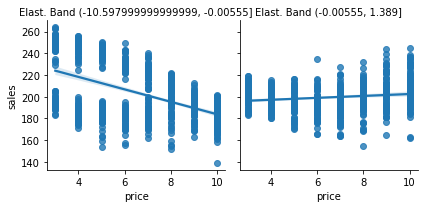

In [14]:
g = sns.FacetGrid(bands_df, col="elast_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Elast. Band {col_name}");

- elasticity를 이용한 경우 위처럼 segment한 것이 유용하게 사용될 것이다.
  - 첫번째의 경우 price에 따라 sensitivity가 크기 때문에 price를 너무 바꾸면(올리면) 안된다.
  - price가 커짐에 따라 sales가 떨어진다.

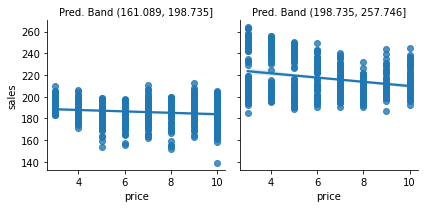

In [15]:
g = sns.FacetGrid(bands_df, col="pred_band")
g.map_dataframe(sns.regplot, x="price", y="sales")
g.set_titles(col_template="Pred. Band {col_name}");

- 이에 반해 ML model은 segment가 그리 유용하지 않다.